## Library Imports
In this section, we import all the necessary libraries required

In [5]:
import os
import cv2
import numpy as np
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.applications import VGG16, ResNet50
from tensorflow.keras.models import Model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import tensorflow as tf


## Data Loading
In this section, we define a function to process the image data.

    Function to perform ETL, EDA, cleaning, and preprocessing on image data.

    Args:
    - data_folder (str): Path to the folder containing image data.
    - test_size (float): Proportion of the dataset to include in the test split.
    - random_state (int): Random seed for reproducibility.

    Returns:
    - train_images (list): List of paths to training images.
    - test_images (list): List of paths to testing images.
    - train_labels (list): List of training labels.
    - test_labels (list): List of testing labels.

In [6]:

# Helper function to load data image 
def load_image_data(image_path, target_size):
    image = cv2.imread(image_path)
    if image is not None:
        image = cv2.resize(image, target_size)
        image = image.astype(np.float32) / 255.0  # Normalize pixel values to [0, 1]
    return image

#### - This function processes image data from a specified folder, splitting it into training, validation, and test sets.
#### - The data is expected to be organized into subfolders for each category (e.g., 'bleached_corals' and 'healthy_corals').
#### - The function returns lists of image paths and corresponding labels for each dataset split.


In [7]:

# Function to process and load image data
def process_image_data(data_folder, test_size=0.1, val_size=0.1, random_state=42, target_size=(224, 224)):
    categories = ['bleached_corals', 'healthy_corals']
    images = []
    labels = []

    for category in categories:
        class_num = categories.index(category)
        folder_path = os.path.join(data_folder, category)
        if not os.path.exists(folder_path):
            raise FileNotFoundError(f"Directory '{folder_path}' does not exist")
        for filename in os.listdir(folder_path):
            img_path = os.path.join(folder_path, filename)
            if os.path.isfile(img_path):
                images.append(img_path)
                labels.append(class_num)


    # Split data into train, validation, and test sets
    train_images, test_val_images, train_labels, test_val_labels = train_test_split(
        images, labels, test_size=test_size + val_size, random_state=random_state
    )
    test_images, val_images, test_labels, val_labels = train_test_split(
        test_val_images, test_val_labels, test_size=val_size / (test_size + val_size), random_state=random_state
    )

    return train_images, val_images, test_images, train_labels, val_labels, test_labels

# Generator function 

The generator function yields batches of images and their corresponding labels, which can be used for training or testing a machine-learning model.

In [8]:
# Generator function for training and testing data
def generator(image_paths, labels, batch_size=32, target_size=(224, 224)):
    while True:
        for start in range(0, len(image_paths), batch_size):
            end = min(start + batch_size, len(image_paths))
            batch_images = []
            batch_labels = []
            for i in range(start, end):
                img = load_image_data(image_paths[i], target_size)
                if img is not None:
                    batch_images.append(img)
                    batch_labels.append(labels[i])
            yield np.array(batch_images), np.array(batch_labels)

# Load an process the image dataset

In [9]:

# Path to the folder containing the images
data_folder = r"C:\Users\7hayf\OneDrive\Desktop\T5\Final_project\Coral_reef1"

# Process and load image data
train_images, val_images, test_images, train_labels, val_labels, test_labels = process_image_data(data_folder)

# Print the lengths of the lists (number of images)
print("Number of training images:", len(train_images))
print("Number of validation images:", len(val_images))
print("Number of testing images:", len(test_images))


Number of training images: 738
Number of validation images: 93
Number of testing images: 92


# Creates data generators 

In [10]:
# Create generators
train_generator = generator(train_images, train_labels)
val_generator = generator(val_images, val_labels)
test_generator = generator(test_images, test_labels)

# CNN model

#### - Defines and compiles a CNN model for coral image classification.
#### - Includes convolutional, max-pooling, dense, and dropout layers.
#### - Uses ReLU and sigmoid activations for intermediate and output layers.
#### - Compiled with Adam optimizer and binary cross-entropy loss.
#### - Trained with training and validation data generators.
#### - Saves the trained model to 'cnn_coral_classifier.h5'.
#### - Evaluates the model on the test set and prints the loss and accuracy.


In [11]:
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(512, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the model with validation data
history = model.fit(
    train_generator,
    steps_per_epoch=len(train_images) // 32,
    epochs=5,
    validation_data=val_generator,
    validation_steps=len(val_images) // 32
)

# Save the model
model.save('cnn_coral_classifier.h5')

# Evaluate the model on the test set
loss, accuracy = model.evaluate(test_generator, steps=len(test_images) // 32)
print(f'Test Loss: {loss}, Test Accuracy: {accuracy}')

C:\Users\7hayf\anaconda3\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/5
23/23 ━━━━━━━━━━━━━━━━━━━━ 37s 1s/step - accuracy: 0.5511 - loss: 1.6855 - val_accuracy: 0.7031 - val_loss: 0.6049
Epoch 2/5
23/23 ━━━━━━━━━━━━━━━━━━━━ 26s 1s/step - accuracy: 0.6488 - loss: 0.6126 - val_accuracy: 0.7541 - val_loss: 0.5293
Epoch 3/5
23/23 ━━━━━━━━━━━━━━━━━━━━ 26s 1s/step - accuracy: 0.7049 - loss: 0.6050 - val_accuracy: 0.7213 - val_loss: 0.5625
Epoch 4/5
23/23 ━━━━━━━━━━━━━━━━━━━━ 26s 1s/step - accuracy: 0.7109 - loss: 0.5673 - val_accuracy: 0.6875 - val_loss: 0.6008
Epoch 5/5
23/23 ━━━━━━━━━━━━━━━━━━━━ 25s 1s/step - accuracy: 0.7054 - loss: 0.5752 - val_accuracy: 0.7213 - val_loss: 0.5507


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 325ms/step - accuracy: 0.7083 - loss: 0.6039
Test Loss: 0.6271286010742188, Test Accuracy: 0.6875


 # create_model function
 ### - We used pre-trained model (VGG16 - RestNet50)
That takes a pre-trained base model as input, adds additional layers on top of it, and compiles the resulting model for training

In [12]:

# Function to create and compile the model
def create_model(base_model):
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(1024, activation='relu')(x)
    predictions = Dense(1, activation='sigmoid')(x)

    model = Model(inputs=base_model.input, outputs=predictions)

    for layer in base_model.layers:
        layer.trainable = False

    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model


In [13]:

# Load VGG16 model
vgg_base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
vgg_model = create_model(vgg_base_model)


In [14]:

# Load ResNet50 model
resnet_base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
resnet_model = create_model(resnet_base_model)


In [15]:

# Train VGG16 model
vgg_history = vgg_model.fit(
    train_generator,
    steps_per_epoch=len(train_images) // 32,
    epochs=10,
    validation_data=test_generator,
    validation_steps=len(test_images) // 32
)


Epoch 1/10
23/23 ━━━━━━━━━━━━━━━━━━━━ 181s 8s/step - accuracy: 0.4956 - loss: 0.8037 - val_accuracy: 0.6875 - val_loss: 0.6316
Epoch 2/10
23/23 ━━━━━━━━━━━━━━━━━━━━ 176s 8s/step - accuracy: 0.7541 - loss: 0.5742 - val_accuracy: 0.7500 - val_loss: 0.5258
Epoch 3/10
23/23 ━━━━━━━━━━━━━━━━━━━━ 165s 7s/step - accuracy: 0.7322 - loss: 0.5577 - val_accuracy: 0.7333 - val_loss: 0.5710
Epoch 4/10
23/23 ━━━━━━━━━━━━━━━━━━━━ 176s 8s/step - accuracy: 0.7481 - loss: 0.5285 - val_accuracy: 0.6875 - val_loss: 0.5834
Epoch 5/10
23/23 ━━━━━━━━━━━━━━━━━━━━ 330s 15s/step - accuracy: 0.7439 - loss: 0.5135 - val_accuracy: 0.7500 - val_loss: 0.4775
Epoch 6/10
23/23 ━━━━━━━━━━━━━━━━━━━━ 174s 8s/step - accuracy: 0.7595 - loss: 0.4925 - val_accuracy: 0.7333 - val_loss: 0.5486
Epoch 7/10
23/23 ━━━━━━━━━━━━━━━━━━━━ 177s 8s/step - accuracy: 0.7665 - loss: 0.4863 - val_accuracy: 0.7031 - val_loss: 0.5647
Epoch 8/10
23/23 ━━━━━━━━━━━━━━━━━━━━ 176s 8s/step - accuracy: 0.7785 - loss: 0.4498 - val_accuracy: 0.7833 - 

In [16]:

# Train ResNet50 model
resnet_history = resnet_model.fit(
    train_generator,
    steps_per_epoch=len(train_images) // 32,
    epochs=10,
    validation_data=test_generator,
    validation_steps=len(test_images) // 32
)


Epoch 1/10
23/23 ━━━━━━━━━━━━━━━━━━━━ 95s 3s/step - accuracy: 0.4935 - loss: 1.1389 - val_accuracy: 0.5156 - val_loss: 0.7886
Epoch 2/10
23/23 ━━━━━━━━━━━━━━━━━━━━ 46s 2s/step - accuracy: 0.5205 - loss: 0.8214 - val_accuracy: 0.5333 - val_loss: 0.9102
Epoch 3/10
23/23 ━━━━━━━━━━━━━━━━━━━━ 31s 1s/step - accuracy: 0.5029 - loss: 0.7807 - val_accuracy: 0.4500 - val_loss: 0.8239
Epoch 4/10
23/23 ━━━━━━━━━━━━━━━━━━━━ 31s 1s/step - accuracy: 0.5165 - loss: 0.7327 - val_accuracy: 0.5000 - val_loss: 0.6995
Epoch 5/10
23/23 ━━━━━━━━━━━━━━━━━━━━ 30s 1s/step - accuracy: 0.5198 - loss: 0.7377 - val_accuracy: 0.5167 - val_loss: 0.7008
Epoch 6/10
23/23 ━━━━━━━━━━━━━━━━━━━━ 30s 1s/step - accuracy: 0.5163 - loss: 0.7247 - val_accuracy: 0.5833 - val_loss: 0.6902
Epoch 7/10
23/23 ━━━━━━━━━━━━━━━━━━━━ 30s 1s/step - accuracy: 0.5292 - loss: 0.7076 - val_accuracy: 0.5156 - val_loss: 0.8172
Epoch 8/10
23/23 ━━━━━━━━━━━━━━━━━━━━ 30s 1s/step - accuracy: 0.5302 - loss: 0.7259 - val_accuracy: 0.4667 - val_loss:

In [17]:

# Save the models
vgg_model.save('vgg16_coral_classifier.h5')
resnet_model.save('resnet50_coral_classifier.h5')


In [18]:

# Evaluate the models
vgg_loss, vgg_accuracy = vgg_model.evaluate(test_generator, steps=len(test_images) // 32)
resnet_loss, resnet_accuracy = resnet_model.evaluate(test_generator, steps=len(test_images) // 32)

print(f'VGG16 Test Loss: {vgg_loss}, Test Accuracy: {vgg_accuracy}')
print(f'ResNet50 Test Loss: {resnet_loss}, Test Accuracy: {resnet_accuracy}')


2/2 ━━━━━━━━━━━━━━━━━━━━ 7s 3s/step - accuracy: 0.7083 - loss: 0.5372
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 1s/step - accuracy: 0.4792 - loss: 0.8974
VGG16 Test Loss: 0.5647807121276855, Test Accuracy: 0.6875
ResNet50 Test Loss: 0.8449434638023376, Test Accuracy: 0.515625


**From these results, it appears that the VGG16 model performed better on Coral reef dataset compared to the ResNet50 model, achieving higher accuracy and lower loss.**

# To improve the model performance:

* Fine-tuning the models by unfreezing some of the deeper layers and training again.
* Trying different hyperparameters, such as learning rate, batch size, or number of epochs.
* Using data augmentation to increase the variability of your training data.

In [19]:
# Function to create and compile the model with fine-tuning
def create_model_with_fine_tuning(base_model, learning_rate):
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(1024, activation='relu')(x)
    predictions = Dense(1, activation='sigmoid')(x)

    model = Model(inputs=base_model.input, outputs=predictions)

    # Unfreeze some layers of the base model
    for layer in base_model.layers[-4:]:
        layer.trainable = True

    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
                  loss='binary_crossentropy',
                  metrics=['accuracy'])
    return model

In [30]:
# Fine-tuning CNN
for layer in model.layers[-4:]:
    layer.trainable = True

# Compile the model with a low learning rate for fine-tuning
model.compile(optimizer=Adam(learning_rate=1e-5), loss='binary_crossentropy', metrics=['accuracy'])

# Fine-tuning training
history_fine_tune = model.fit(
    train_generator,
    steps_per_epoch=len(train_images) // 32,
    epochs=5,
    validation_data=val_generator,
    validation_steps=len(val_images) // 32
)

# Save the fine-tuned model
model.save('cnn_coral_classifier_fine_tuned.h5')

# Evaluate the fine-tuned model on the test set
loss, accuracy = model.evaluate(test_generator, steps=len(test_images) // 32)
print(f'Test Loss: {loss}, Test Accuracy: {accuracy}')


Epoch 1/5
23/23 ━━━━━━━━━━━━━━━━━━━━ 18s 630ms/step - accuracy: 0.7885 - loss: 0.4813 - val_accuracy: 0.7344 - val_loss: 0.5221
Epoch 2/5
23/23 ━━━━━━━━━━━━━━━━━━━━ 14s 608ms/step - accuracy: 0.7986 - loss: 0.4612 - val_accuracy: 0.7705 - val_loss: 0.4738
Epoch 3/5
23/23 ━━━━━━━━━━━━━━━━━━━━ 14s 592ms/step - accuracy: 0.8069 - loss: 0.4610 - val_accuracy: 0.7541 - val_loss: 0.5165
Epoch 4/5
23/23 ━━━━━━━━━━━━━━━━━━━━ 14s 603ms/step - accuracy: 0.8016 - loss: 0.4881 - val_accuracy: 0.7188 - val_loss: 0.5189
Epoch 5/5
23/23 ━━━━━━━━━━━━━━━━━━━━ 14s 601ms/step - accuracy: 0.7670 - loss: 0.4664 - val_accuracy: 0.7541 - val_loss: 0.4676


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step - accuracy: 0.6979 - loss: 0.6225
Test Loss: 0.6100031137466431, Test Accuracy: 0.703125


In [25]:

# Fine-tune VGG16 model
vgg_fine_tuned_model = create_model_with_fine_tuning(vgg_base_model, learning_rate=1e-5)
vgg_fine_tuned_history = vgg_fine_tuned_model.fit(
    train_generator,
    steps_per_epoch=len(train_images) // 32,
    epochs=10,
    validation_data=test_generator,
    validation_steps=len(test_images) // 32
)

# Save the fine-tuned VGG16 model
vgg_fine_tuned_model.save('vgg16_coral_classifier_fine_tuned.h5')

Epoch 1/10
23/23 ━━━━━━━━━━━━━━━━━━━━ 92s 4s/step - accuracy: 0.4750 - loss: 0.6984 - val_accuracy: 0.5156 - val_loss: 0.6784
Epoch 2/10
23/23 ━━━━━━━━━━━━━━━━━━━━ 86s 4s/step - accuracy: 0.5763 - loss: 0.6565 - val_accuracy: 0.7333 - val_loss: 0.6257
Epoch 3/10
23/23 ━━━━━━━━━━━━━━━━━━━━ 86s 4s/step - accuracy: 0.7283 - loss: 0.6059 - val_accuracy: 0.7333 - val_loss: 0.5857
Epoch 4/10
23/23 ━━━━━━━━━━━━━━━━━━━━ 88s 4s/step - accuracy: 0.7219 - loss: 0.5519 - val_accuracy: 0.7500 - val_loss: 0.5984
Epoch 5/10
23/23 ━━━━━━━━━━━━━━━━━━━━ 136s 6s/step - accuracy: 0.7561 - loss: 0.5100 - val_accuracy: 0.7333 - val_loss: 0.5283
Epoch 6/10
23/23 ━━━━━━━━━━━━━━━━━━━━ 92s 4s/step - accuracy: 0.7526 - loss: 0.4958 - val_accuracy: 0.7833 - val_loss: 0.5324
Epoch 7/10
23/23 ━━━━━━━━━━━━━━━━━━━━ 91s 4s/step - accuracy: 0.7560 - loss: 0.5074 - val_accuracy: 0.7500 - val_loss: 0.5847
Epoch 8/10
23/23 ━━━━━━━━━━━━━━━━━━━━ 89s 4s/step - accuracy: 0.7860 - loss: 0.4627 - val_accuracy: 0.7500 - val_loss

In [26]:
# Fine-tune ResNet50 model
resnet_fine_tuned_model = create_model_with_fine_tuning(resnet_base_model, learning_rate=1e-5)
resnet_fine_tuned_history = resnet_fine_tuned_model.fit(
    train_generator,
    steps_per_epoch=len(train_images) // 32,
    epochs=10,
    validation_data=test_generator,
    validation_steps=len(test_images) // 32
)

# Save the fine-tuned ResNet50 model
resnet_fine_tuned_model.save('resnet50_coral_classifier_fine_tuned.h5')

Epoch 1/10
23/23 ━━━━━━━━━━━━━━━━━━━━ 44s 1s/step - accuracy: 0.5165 - loss: 0.6945 - val_accuracy: 0.5469 - val_loss: 0.6919
Epoch 2/10
23/23 ━━━━━━━━━━━━━━━━━━━━ 29s 1s/step - accuracy: 0.5241 - loss: 0.6844 - val_accuracy: 0.4833 - val_loss: 0.6946
Epoch 3/10
23/23 ━━━━━━━━━━━━━━━━━━━━ 30s 1s/step - accuracy: 0.5463 - loss: 0.6747 - val_accuracy: 0.5000 - val_loss: 0.7022
Epoch 4/10
23/23 ━━━━━━━━━━━━━━━━━━━━ 31s 1s/step - accuracy: 0.5946 - loss: 0.6690 - val_accuracy: 0.5312 - val_loss: 0.6891
Epoch 5/10
23/23 ━━━━━━━━━━━━━━━━━━━━ 30s 1s/step - accuracy: 0.6204 - loss: 0.6614 - val_accuracy: 0.5333 - val_loss: 0.6922
Epoch 6/10
23/23 ━━━━━━━━━━━━━━━━━━━━ 30s 1s/step - accuracy: 0.6237 - loss: 0.6599 - val_accuracy: 0.4500 - val_loss: 0.7100
Epoch 7/10
23/23 ━━━━━━━━━━━━━━━━━━━━ 30s 1s/step - accuracy: 0.6241 - loss: 0.6554 - val_accuracy: 0.5156 - val_loss: 0.6888
Epoch 8/10
23/23 ━━━━━━━━━━━━━━━━━━━━ 30s 1s/step - accuracy: 0.6296 - loss: 0.6565 - val_accuracy: 0.5333 - val_loss:

In [27]:
# Ensure the fine-tuned models are loaded
vgg_fine_tuned_model = tf.keras.models.load_model('vgg16_coral_classifier_fine_tuned.h5')
resnet_fine_tuned_model = tf.keras.models.load_model('resnet50_coral_classifier_fine_tuned.h5')

# Evaluate the fine-tuned VGG16 model
vgg_fine_tuned_loss, vgg_fine_tuned_accuracy = vgg_fine_tuned_model.evaluate(test_generator, steps=len(test_images) // 32)
print(f'Fine-tuned VGG16 Test Loss: {vgg_fine_tuned_loss}, Test Accuracy: {vgg_fine_tuned_accuracy}')

# Evaluate the fine-tuned ResNet50 model
resnet_fine_tuned_loss, resnet_fine_tuned_accuracy = resnet_fine_tuned_model.evaluate(test_generator, steps=len(test_images) // 32)
print(f'Fine-tuned ResNet50 Test Loss: {resnet_fine_tuned_loss}, Test Accuracy: {resnet_fine_tuned_accuracy}')


2/2 ━━━━━━━━━━━━━━━━━━━━ 7s 3s/step - accuracy: 0.7396 - loss: 0.5872
Fine-tuned VGG16 Test Loss: 0.5888693332672119, Test Accuracy: 0.75
2/2 ━━━━━━━━━━━━━━━━━━━━ 7s 1s/step - accuracy: 0.5417 - loss: 0.6787
Fine-tuned ResNet50 Test Loss: 0.687849760055542, Test Accuracy: 0.515625


## Plot Learning Curves Function and Usage

#### - This function plots training and validation accuracy and loss over epochs from the model's training history.


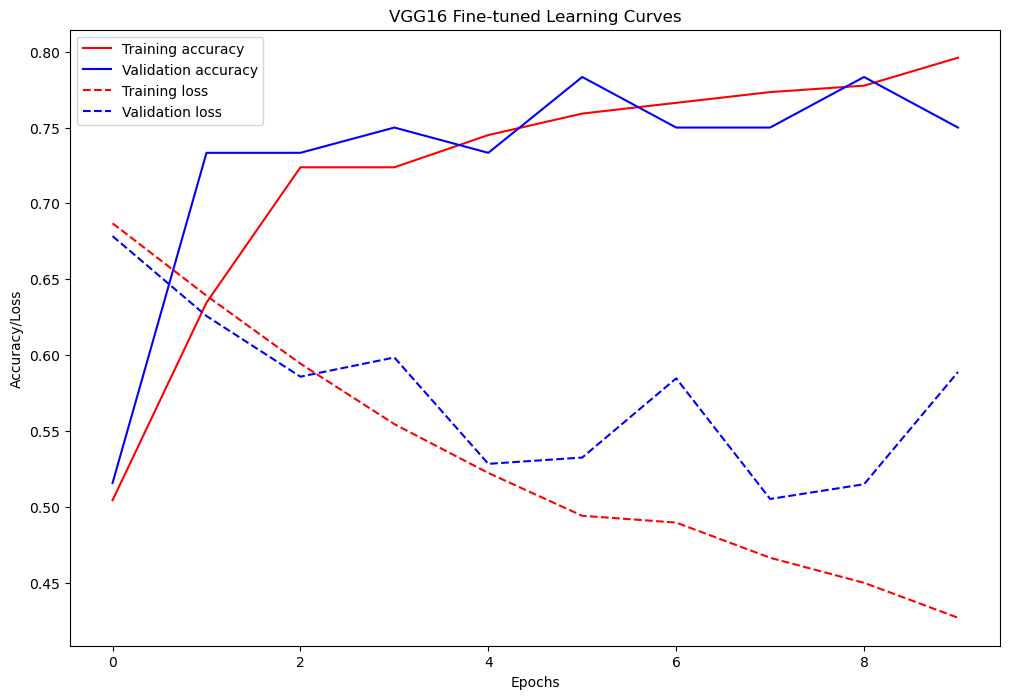

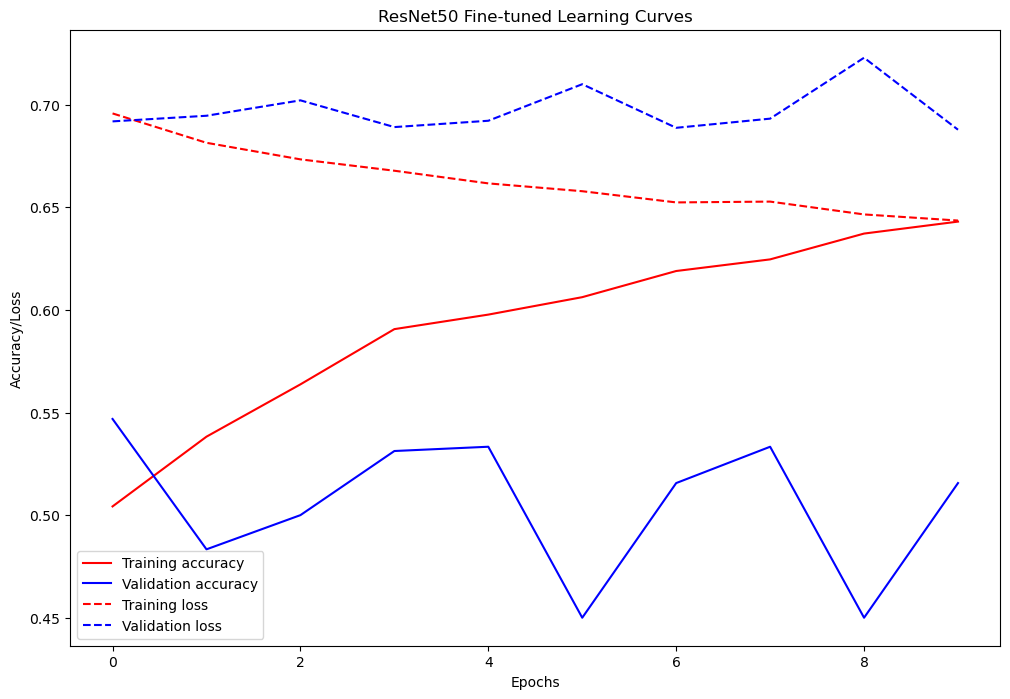

In [28]:
import matplotlib.pyplot as plt

def plot_learning_curves(history, title):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(len(acc))

    plt.figure(figsize=(12, 8))
    plt.plot(epochs, acc, 'r', label='Training accuracy')
    plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
    plt.plot(epochs, loss, 'r--', label='Training loss')
    plt.plot(epochs, val_loss, 'b--', label='Validation loss')
    plt.title(title)
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy/Loss')
    plt.legend()
    plt.show()

# Plot learning curves for VGG16
plot_learning_curves(vgg_fine_tuned_history, 'VGG16 Fine-tuned Learning Curves')

# Plot learning curves for ResNet50
plot_learning_curves(resnet_fine_tuned_history, 'ResNet50 Fine-tuned Learning Curves')


# Confusion Matrix for Coral Classification
#### - Loads a pre-trained coral classification model.
#### - Generates predictions for the test set and computes a confusion matrix.
#### - Plots the confusion matrix and prints a classification report.



1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 392ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 213ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 328ms/step


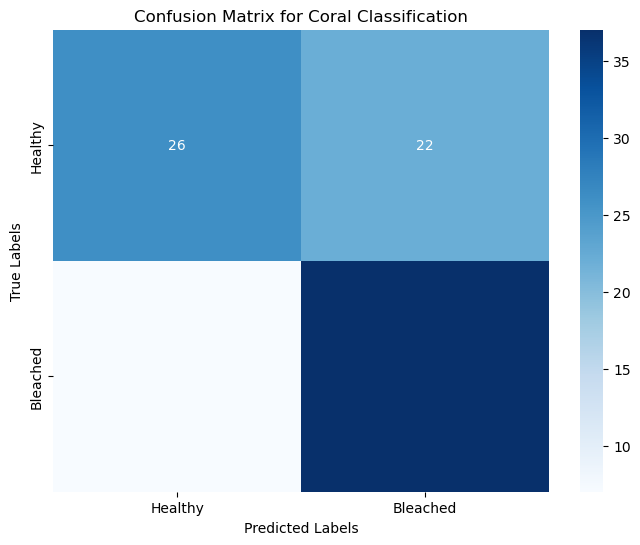

              precision    recall  f1-score   support

     Healthy       0.79      0.54      0.64        48
    Bleached       0.63      0.84      0.72        44

    accuracy                           0.68        92
   macro avg       0.71      0.69      0.68        92
weighted avg       0.71      0.68      0.68        92



In [29]:
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import tensorflow as tf

# Assuming your coral model is already trained and saved
coral_model = tf.keras.models.load_model('cnn_coral_classifier.h5')

# Generate predictions for the test set
true_labels_coral = []
pred_labels_coral = []

for images, labels in generator(test_images, test_labels, batch_size=32, target_size=(224, 224)):
    preds = coral_model.predict(images)
    preds = (preds > 0.5).astype(int)  # Binarize predictions
    true_labels_coral.extend(labels)
    pred_labels_coral.extend(preds)
    if len(true_labels_coral) >= len(test_images):
        break

true_labels_coral = np.array(true_labels_coral)
pred_labels_coral = np.array(pred_labels_coral)

# Generate confusion matrix for coral classification
coral_conf_matrix = confusion_matrix(true_labels_coral, pred_labels_coral)

# Plot confusion matrix for coral classification
plt.figure(figsize=(8, 6))
sns.heatmap(coral_conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Healthy', 'Bleached'],
            yticklabels=['Healthy', 'Bleached'])
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix for Coral Classification')
plt.show()

# Print classification report for coral classification
print(classification_report(true_labels_coral, pred_labels_coral, target_names=['Healthy', 'Bleached']))
